In [1]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline

In [2]:
from branchynet.net import BranchyNet
from branchynet.links import *
import chainer.functions as F
import chainer.links as L
from branchynet import utils, visualize
from chainer import cuda

Define Network

In [3]:
from networks import alex_cifar10

branchyNet = alex_cifar10.get_network()
branchyNet.to_gpu()
branchyNet.training()

Import Data

In [4]:
from datasets import pcifar10

x_train,y_train,x_test,y_test = pcifar10.get_data()

Settings

In [5]:
TRAIN_BATCHSIZE = 512
TEST_BATCHSIZE = 1
TRAIN_NUM_EPOCHS = 50

Train Main Network

In [6]:
main_loss, main_acc, main_time = utils.train(branchyNet, x_train, y_train, main=True, batchsize=TRAIN_BATCHSIZE,
                                             num_epoch=TRAIN_NUM_EPOCHS)

Train BranchyNet

In [7]:
TRAIN_NUM_EPOCHS = 100
branch_loss, branch_acc, branch_time = utils.train(branchyNet, x_train, y_train, batchsize=TRAIN_BATCHSIZE,
                                             num_epoch=TRAIN_NUM_EPOCHS)

#set network to inference mode
branchyNet.testing()

Visualizing Network Training

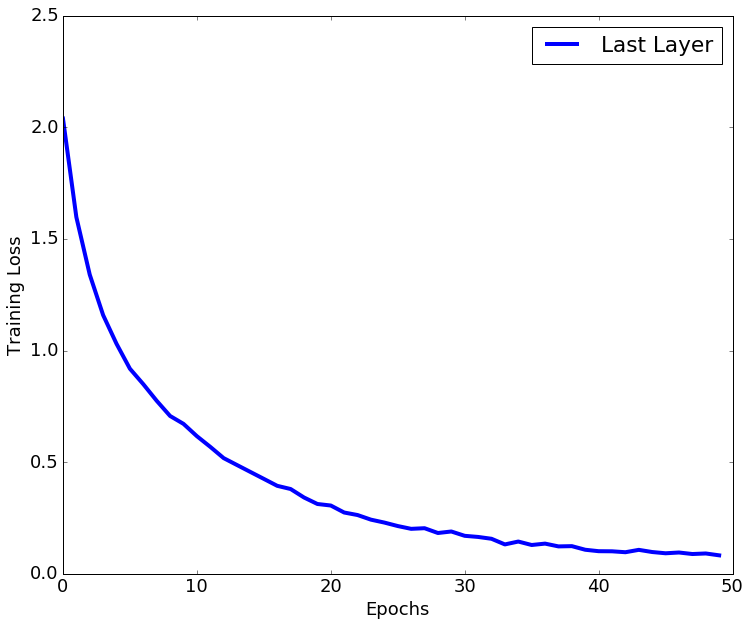

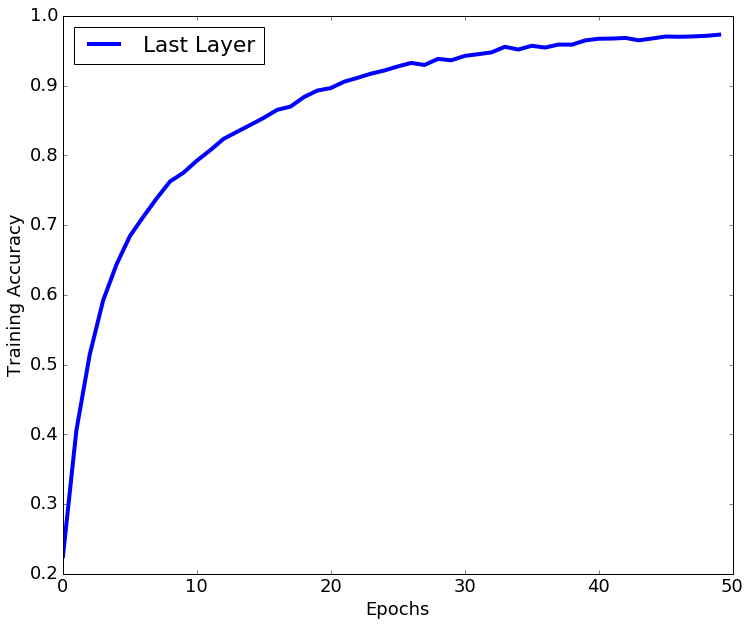

In [8]:
visualize.plot_layers(main_loss, xlabel='Epochs', ylabel='Training Loss')
visualize.plot_layers(main_acc, xlabel='Epochs', ylabel='Training Accuracy')

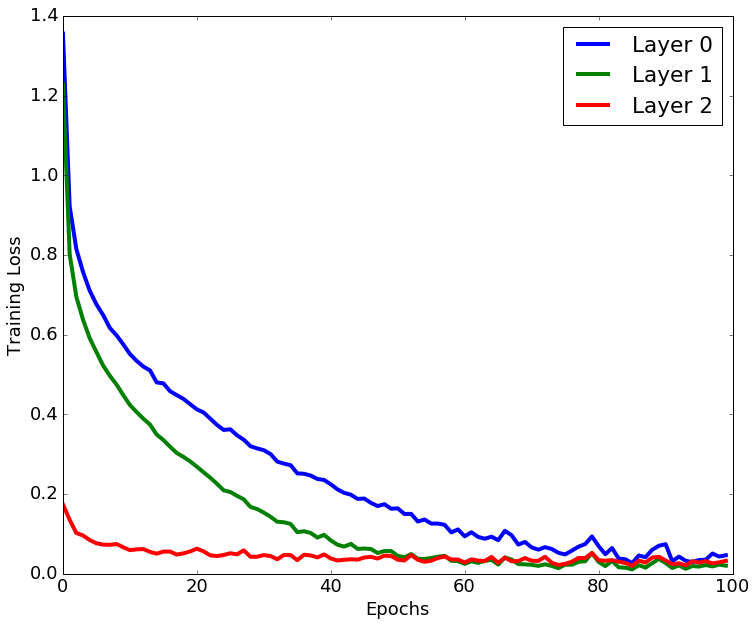

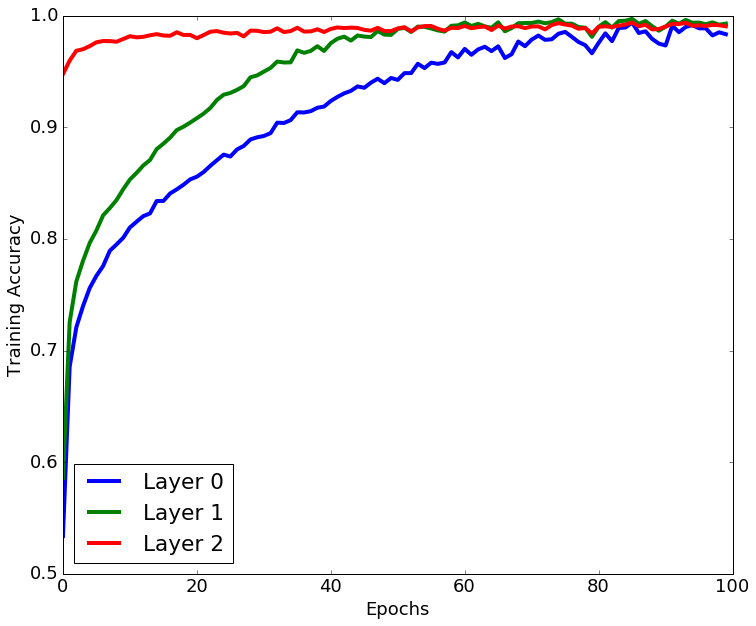

In [9]:
visualize.plot_layers(zip(*branch_loss), xlabel='Epochs', ylabel='Training Loss')
visualize.plot_layers(zip(*branch_acc), xlabel='Epochs', ylabel='Training Accuracy')

Run test suite and visualize

In [10]:
#set network to inference mode
branchyNet.testing()
branchyNet.verbose = False
branchyNet.to_gpu()
g_baseacc, g_basediff, _, _ = utils.test(branchyNet,x_test,y_test,main=True,batchsize=TEST_BATCHSIZE)
g_basediff = (g_basediff / float(len(y_test))) * 1000.

#branchyNet.to_cpu()
c_baseacc, c_basediff, _, _ = utils.test(branchyNet,x_test,y_test,main=True,batchsize=TEST_BATCHSIZE)
c_basediff = (c_basediff / float(len(y_test))) * 1000.

In [11]:
# Specify thresholds
thresholds = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.75, 1., 5., 10.]

In [12]:
#GPU
branchyNet.to_gpu()
g_ts, g_accs, g_diffs, g_exits = utils.screen_branchy(branchyNet, x_test, y_test, thresholds,
                                                    batchsize=TEST_BATCHSIZE, verbose=True)

#convert to ms
g_diffs *= 1000.

C:\Users\Kung Lab\Miniconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


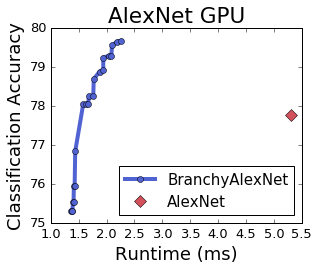

In [13]:
visualize.plot_line_tradeoff(g_accs, g_diffs, g_ts, g_exits, g_baseacc, g_basediff, all_samples=False, inc_amt=-0.0001000,
                             our_label='BranchyAlexNet', orig_label='AlexNet', xlabel='Runtime (ms)', 
                             title='AlexNet GPU', output_path='_figs/alexnet_gpu.pdf')

In [14]:
#CPU
branchyNet.to_cpu()
c_ts, c_accs, c_diffs, c_exits  = utils.screen_branchy(branchyNet, x_test, y_test, thresholds,
                                                     batchsize=TEST_BATCHSIZE, verbose=True)

#convert to ms
c_diffs *= 1000.

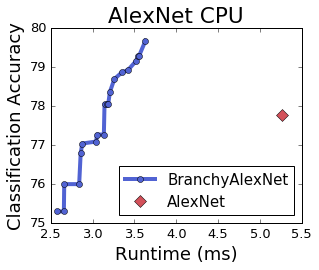

In [15]:
visualize.plot_line_tradeoff(c_accs, c_diffs, c_ts, c_exits, c_baseacc, c_basediff, all_samples=False, inc_amt=-0.0001000,
                             our_label='BranchyAlexNet', orig_label='AlexNet', xlabel='Runtime (ms)',
                             title='AlexNet CPU', output_path='_figs/alexnet_cpu.pdf')

In [18]:
reload(utils)
print 'CPU Results:'
utils.branchy_table_results('AlexNet', c_baseacc, c_basediff, c_accs, c_diffs, c_exits, c_ts)

print '\n\n'

print 'GPU Results:'
utils.branchy_table_results('AlexNet', g_baseacc, g_basediff, g_accs, c_diffs, g_exits, g_ts)

CPU Results:
        Network        Acc.(%)       Time(ms)           Gain      Thrshld.T        Exit(%)
        AlexNet          77.76           5.26              -              -              -
      B-AlexNet          78.94           4.55           1.16{0.0001, 0.0001}{43.61, 17.41, 38.98}
      B-AlexNet          79.16           4.48           1.17{0.0001, 0.001}{43.61, 23.21, 33.18}
      B-AlexNet          79.27           4.39           1.20{0.0001, 0.005}{43.61, 27.82, 28.57}
      B-AlexNet          79.37           4.46           1.18 {0.0001, 0.01}{43.61, 29.96, 26.43}
      B-AlexNet          79.36           4.11           1.28 {0.0001, 0.05}{43.61, 35.79, 20.6}
      B-AlexNet          79.18           4.03           1.30  {0.0001, 0.1}{43.61, 38.98, 17.41}
      B-AlexNet          78.38           3.83           1.37  {0.0001, 0.5}{43.61, 48.45, 7.94}
      B-AlexNet          77.53           3.67           1.43 {0.0001, 0.75}{43.61, 54.43, 1.96}
      B-AlexNet          77.33 

Save model/data

In [19]:
import dill
branchyNet.to_cpu()
with open("_models/alexnet_cifar10.bn", "wb") as f:
    dill.dump(branchyNet, f)
with open("_models/alexnet_cifar10_gpu_results.pkl", "wb") as f:
    dill.dump({'accs': g_accs, 'rt': g_diffs, 'exits': g_exits, 'ts': g_ts, 'baseacc': g_baseacc, 'basediff': g_basediff}, f)
with open("_models/alexnet_cifar10_cpu_results.pkl", "wb") as f:
    dill.dump({'accs': c_accs, 'rt': c_diffs, 'exits': c_exits, 'ts': c_ts, 'baseacc': c_baseacc, 'basediff': c_basediff}, f)

In [20]:
import dill
with open("_models/lenet_mnist_gpu_results.pkl", "rb") as f:
    gpu_res = dill.load(f)
with open("_models/lenet_mnist_cpu_results.pkl", "rb") as f:
    cpu_res = dill.load(f)